## Quick Links

[Cleaning Data](#Cleaning-Data)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Notes](#Notes:)  
[Standard Analysis](#Standard-Analysis)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Reward Leaning](#Reward-Learning)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Discriminability](#Discriminability)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Accuracy](#Accuracy)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Reaction Time](#Reaction-Time)   
[HDDM Analysis](#HDDM-Analysis)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Within model](#Within-model)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Between model](#Between-model)  

In [2]:
import datetime, mmap,os,re, sys, decimal, hddm
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy as sp
from patsy import dmatrix
import warnings 
warnings.filterwarnings('ignore')# I'm sick of all the red.
os.environ['R_HOME'] = '/Users/mlm2/anaconda/envs/pythonthreefive/lib/R' # couldn't find R in this environment for some reason
% matplotlib inline 
% reload_ext rpy2.ipython
%R library(lsmeans)
%R library(afex)
%R library(ppcor)

array(['ppcor', 'MASS', 'afex', 'reshape2', 'lme4', 'Matrix', 'lsmeans',
       'estimability', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], 
      dtype='<U12')

# Cleaning Data

Results in two csvs: **Data/prt_standard_first_session.csv** (which contains all of the "standard" data) & **Data/prt_all_trials_first_session.csv** (which contains all of the trial level data, merged with the relevant "standard" data).  
  
Can skip this section if you already have these files.

In [ ]:
pwd

In [ ]:
ls

In [ ]:
uname = !whoami
uname = uname[0]
path2analysis = '/Users/' + uname + '/Work/Expts/EMBARC/' # also where git repo lives
today = datetime.datetime.today().strftime("%m_%d_%Y")

In [ ]:
for val in [('Massachusetts','MG'),('Michigan','UM'),('New_York','CU'),('Texas','TX')]:
    state, abrev = val
    base_dir = '/Users/' + uname + '/Work/Expts/EMBARC/Data/PRT/' + state + '/'
    temp_dir = base_dir + abrev + 'Temp/'
    old_files = base_dir + 'embarc_CU_' + abrev + '0*/done/sigdet_output*out'
    flist = !ls {old_files}
    
    !mkdir {temp_dir}
    
    for old_fname in flist:
        if abrev != 'CU':
            sub = old_fname.split('_')[2]
        else:
            sub = old_fname.split('_')[3]
        new_file = sub + '_out.txt'
        new_fname = temp_dir + new_file
        
        !cp {old_fname} {new_fname} # Done this way you don't get error messages when there's no old file

In [ ]:
def SigDetParse(fname):
    '''Open the file, use regex to pull out key vars, output a clean df.'''
    
    df = []
    d = {}
    ct = 0
    
    # Begin reading in data from the line including 'reward_due', as that's unlikely to occur anywhere earlier
    with open(fname) as f:
        for line in f:
            if 'reward_due' in line:
                for line in f:
                    d[ct] = {'trial':line.split('\t')[0],
                             'length':line.split('\t')[1],
                             'time':line.split('\t')[2], # tempting to change to RT but keep same for backwards compat
                             'key_press':line.split('\t')[3],
                             'correct':line.split('\t')[4],
                             'did_reward':line.split('\t')[5],
                             'reward_due':line.split('\t')[6],
                             'rich_due':line.split('\t')[7],
                             'lean_due':line.split('\t')[8],
                             'outlier':line.split('\t')[9].strip('\n')}
                    ct = ct + 1
    df = pd.DataFrame.from_dict(d,orient='index')
    

    for val in [('rich_key','Rich key:'),('lean_key','Lean key:'), ('subject','Subject ID:'), ('date','Date:'), 
                ('bias','Bias:'), ('rich_stim','Rich stimulus:'), ('lean_stim','Lean stimulus:')]:
        
        var_name, pattern = val
        df[var_name] = np.nan # Need some default values b/c some subjects have missing data        

        if var_name != 'date':
            var_def = re.compile(pattern + '[\s]+([\w]+)')
        else:
            var_def = re.compile(pattern + '[\s]+([\d]+/[\d]+/[\d]+)')
        
        with open(fname) as f:
            for line in f:
                var_match = var_def.search(line)
                if var_match:
                    result = var_match.group(1)
                    #checks if the subject ID is weird, prints it, and fixes it. For this data, all 3 digit sub ids
                    #are fixed by adding a 0 to the beginning. 
                    if var_name =='subject' and len(result) !=4:
                        print ('Check sub ID: ' + fname)
                        if len(result) == 3:
                            df[var_name]='0'+ result
                        if len(result) == 1:
                            df[var_name] ='000' + result
                    else:
                        df[var_name] = result

    return df

In [ ]:
# Now you can just iterate over the files in each dir and use the code above to read each file into a ginorm df
today = datetime.datetime.today().strftime("%m_%d_%Y")

dfs = []
base_dir = '/Users/' + uname + '/Work/Expts/EMBARC/Data/PRT/'
for val in [('Massachusetts','MG'),('Michigan','UM'),('New_York','CU'),('Texas','TX')]:
    state, abrev = val
    state_dir = base_dir + state + '/' + abrev + 'Temp'
    flist = !ls {state_dir}
    
    for fname in flist:
        curr_path = state_dir + '/' + fname 
        statinfo = os.stat(curr_path) # checking for empty files b/c I found one . . .
        if statinfo.st_size == 0:
            #to make it compatible with 2 & 3
            print ('Empty file: '+ curr_path)
        else:
            df = SigDetParse(curr_path)
            df['site'] = abrev
            df['ProjectSpecificID'] = df['site'] + df['subject']
            dfs.append(df)
out = pd.concat(dfs)
out = out[['ProjectSpecificID','site','subject','date','bias','rich_stim','lean_stim','rich_key','lean_key',
           'trial','length','time','key_press','correct','did_reward','reward_due','rich_due','lean_due','outlier']]

In [ ]:
# adding in the blocks
out['trial'] = pd.to_numeric(out['trial'])
out.loc[out['trial'] <= 100, 'block'] = 1
out.loc[out['trial'] > 100, 'block'] = 2

In [ ]:
# Check that change fixed the wacky numbers, looks like it did
out.subject.unique()

In [31]:
df_group = pd.read_csv('Data/groups.csv',encoding="latin-1")
df_compact = []
df_compact = df_group[['ProjectSpecificID', 'feasibility', 'shaps_total_dichotomous', 
                       'shaps_total_continuous', 'severity1', 'conmed_16', 'conmed_11', 'conmed_06', 'conmed_01', 'partic_age', 'partic_gender', 'masq2_29', 'hamd_09']]

In [ ]:
# for all states extract the standard data and put into one file

df_stand = pd.DataFrame()
for state in ['Massachusetts', 'Michigan', 'New_York', 'Texas']:
    df_state = pd.DataFrame()
    statesum = '/Users/'+ uname +'/Work/Expts/EMBARC/Data/PRT/'+ state +'/Summaries/embarc*/*txt'
    folders  = !ls -d {statesum}
    
    for filename in folders:
        if filename != 'embarc_MG_subj_PRTsess_.txt' and filename != 'embarc_NY_subj_PRTsess_.txt'and filename != 'embarc_NY_subj****************_PRTsess2_short.txt' and filename != 'embarc_TX_subj_PRTsess_.txt' and filename != 'embarc_UM_subj_PRTsess_.txt' and filename !='Note.txt':
            x = pd.read_csv(filename, delim_whitespace = True, dtype={'subject':str, 'PRT_QC_Status':str, 'session':str})
            if 'subject' in x.columns:
                x.subject = x.subject.str.zfill(4) #fixing weird IDs
                df_stand = pd.concat([x, df_stand])
                df_state = pd.concat([x, df_state])
        
    df_state['ProjectSpecificID'] = df_state['site'] + df_state['subject'] 
    df_state = df_state[pd.notnull(df_state['subject'])]
    df_state = df_state[df_state.subject != '****************'] #we don't care about this person
    df_state.loc[df_state['site'] == 'NY', 'site'] = 'CU'# it's NY in this file
    df_state.to_csv('standard_' + state + '_' + today + '.csv')

df_stand = df_stand[df_stand.subject != '****************']
df_stand = df_stand[pd.notnull(df_stand['subject'])]
df_stand.loc[df_stand['site'] == 'NY', 'site'] = 'CU'
df_stand['ProjectSpecificID'] = df_stand['site'] + df_stand['subject']

Outputs the final "standard" data file

In [ ]:
df_group_comp = df_compact[pd.notnull(df_compact['feasibility'])] # only care where there is a val for feasibility
df_group_comp = df_group_comp.loc[df_group_comp['feasibility'] != 2] # don't care if it's 2
   
df_group_comp.loc[df_group_comp['feasibility'] == 1, 'feasibility'] = 'MDD'
df_group_comp.loc[df_group_comp['feasibility'] == 3, 'feasibility'] = 'MDD'
df_group_comp.loc[df_group_comp['feasibility'] == 5, 'feasibility'] = 'MDD'
df_group_comp.loc[df_group_comp['feasibility'] == 4, 'feasibility'] = 'CTL'# make the feasibility clearer (and strs for HDDM)
    
df_stand_clean = df_stand.merge(df_group_comp, how='outer')# merge on the compact groups data
df_stand_clean.loc[df_stand_clean['ProjectSpecificID'] == 'MG0020', 'session'] = '1' #recode this presumed typo
df_stand_clean = df_stand_clean.loc[df_stand_clean['PRT_QC_Status'] == '1']
df_stand_clean = df_stand_clean[pd.notnull(df_stand_clean['feasibility'])]
df_firstsess = df_stand_clean.loc[df_stand_clean['session'] == '1']
df_firstsess['ID_date'] = df_firstsess['ProjectSpecificID'] + df_firstsess['date1']
df_firstsess = df_firstsess[df_firstsess.ID_date != 'MG002010_24_2012'] #for some reason the second date was listed first
df_firstsess = df_firstsess.drop_duplicates('ProjectSpecificID') # takes the first session listed for each participant
                                                               # we should try playing around with this for MA since our
                                                               # descriptives are slightly different from Christians
df_firstsess = df_firstsess.loc[df_firstsess['ProjectSpecificID'] != 'CU0019'] 
df_firstsess = df_firstsess.loc[df_firstsess['ProjectSpecificID'] != 'UM0102']
df_firstsess = df_firstsess.loc[df_firstsess['ProjectSpecificID'] != 'MG0026']
df_firstsess = df_firstsess.loc[df_firstsess['ProjectSpecificID'] != 'CU0047'] # based on Christian's data, remove 
                                                                               # these subjects 
# Comparing to Christian's list
df_christian = pd.read_csv('/Users/mlm2/Work/Expts/EMBARC/Data/christian_included.txt', header = None)    
christian_list = df_christian[0].astype(str)

# are we missing anything?
for subject in christian_list:
    if subject in df_firstsess.ProjectSpecificID.unique():
        pass
    else:
        print('Missing from ours: '+ subject)

# do we have anything extra?
for subject in df_firstsess.ProjectSpecificID:
    if subject in christian_list.unique():
        pass
    else:
        print('Not included in Christians: ' + subject)
    
#save the first session standard file
df_firstsess.to_csv('Data/prt_standard_first_session.csv')

Outputs the final trial-level data

In [ ]:
df_firstsess['date'] = df_firstsess['date1'].replace(to_replace = '_', value ='/', regex = True)
df_firstsess.date.replace(to_replace = '_', value ='/')
df_trial_merged = out.merge(df_firstsess, how = 'outer', on = ['ProjectSpecificID', 'date']) # FIX THE DATE FORMAT AND MERGE 
                                                                                    # ON DATE TOO
df_trial_merged = df_trial_merged[pd.notnull(df_trial_merged['ProjectSpecificID'])]

df_trial_merged = df_trial_merged[pd.notnull(df_trial_merged['feasibility'])]
# renaming time & correct; the hddm package requires specific column names
df_trial_merged.rename(columns={'time':'rt', 'correct': 'response', 'ProjectSpecificID': 'subj_idx'}, inplace = True)

# number of outlier trials and non-outlier trials for the FIRST session
print(df_trial_merged.outlier.value_counts())

# don't include the outlier trials
df_trial_merged = df_trial_merged[df_trial_merged.outlier == '0']
print(df_trial_merged.outlier.value_counts())

# don't include duplicates (a few people in multiple times)
df_trial_merged = df_trial_merged.drop_duplicates()
df_trial_merged['rt_num'] = pd.to_numeric(df_trial_merged['rt'])
df_trial_merged['response_num'] = pd.to_numeric(df_trial_merged['response'])
df_block1 = df_trial_merged[df_trial_merged['block'] == 1]
df_block2 = df_trial_merged[df_trial_merged['block'] == 2]

# THIS IS THE FILE TO USE FOR THE HDDM
df_trial_merged.to_csv('Data/prt_all_trials_first_session.csv')

## Notes:
#### Massachusetts:
MG0081 & MG0164 had two sessions labled '1.' Since both sessions were complete, the ones with the earlier dates were used. Christian included MG020, which was originally coded as only having a session two; this was probably a typo and I included it. After these corrections everything matched, except that Christian's list included MG0164 twice (so our n for MDDs is one less than his). 

Our descriptives look the same as Christian's after dropping MG0020's second session and using the one on 10/17. The way it was initially coded it was keeping the old one. 

#### New York: 
CU0017, CU0018, and CU0019 had two sessions labled '1.' Since both sessions were complete and had all data I just took the ones with the earlier dates. Christian also excluded CU0047, so I removed them from ours. It's unclear from the data why they were excluded. 

Our descriptives look the same as Christian's.
#### Michigan:
UM0012 & UM0017 had two sessions labled '1.' Since both sessions were complete I took the first of the two for each. UM0016 had three lines of the exact same session 1 data, so I only included the first line. Christian also excluded UM0102, so I removed them from ours. It's unclear from the data why they were excluded.

Our descriptives look the same as Christian's except our MDD n is 51 and his is 52. I would guess that UM0102 was not included in the list of subIDs that were included, but was included when doing the descriptives. We should decide whether or not to keep this person. 
#### Texas:
Everything lined up with no alterations!

Our descriptives look the same as Christian's.

# Standard Analysis

load in the csvs...

In [20]:
df_standard = pd.read_csv('Data/prt_standard_first_session.csv')
df_trial = pd.read_csv('Data/prt_all_trials_first_session.csv')

/Users/mlm2/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (133,134) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [21]:
# we need to trim df_trial down or else r2py will freak out...
df_trial = df_trial[['subj_idx', 'site_x', 'trial', 'length', 'rt', 'response', 'outlier', 'block','feasibility', 'partic_age', 'partic_gender', 'shaps_total_dichotomous', 'RB_adjst_all_Blk2_minus_Blk1', 'shaps_total_continuous']]
df_trial.to_csv('Data/prt_trial_compact.csv')

# Participant Characteristics

## Age

In [ ]:
sp.stats.ttest_ind(df_standard[(df_standard.feasibility == 'MDD')]['partic_age'],
                   df_standard[(df_standard.feasibility == 'CTL')]['partic_age'])

In [ ]:
df_standard[(df_standard.feasibility == 'MDD')]['partic_age'].describe()

In [ ]:
df_standard[(df_standard.feasibility == 'CTL')]['partic_age'].describe()

## Gender

In [ ]:
print (df_standard.groupby('feasibility')['partic_gender'].value_counts())

In [ ]:
obs = np.array([[21,15],[172,86]])
chi2, p, dof, expected = sp.stats.chi2_contingency(obs,correction=False)
print ("Chi-square on Gender: chi-square = " + "{:.2f}".format(chi2) + "; df = " + "{:.2f}".format(dof) + \
"; p = " + "{:.2f}".format(p))

## Reward Learning

Group X Site ANOVA

In [ ]:
reward_learning_plot = sns.barplot(y='RB_adjst_all_Blk2_minus_Blk1', x = 'site', 
                                   data = df_standard, hue = 'feasibility', ci=68)
%Rpush df_standard
%R reward_learning_anova <- aov_ez("ProjectSpecificID", dv = "RB_adjst_all_Blk2_minus_Blk1", data = df_standard, between = c("feasibility","site"),anova_table=list(correction="none", es = "none"))
%R print (reward_learning_anova)

Group X Site ANCOVA (discriminability)

In [ ]:
%R reward_learning_ancova <- aov_ez("ProjectSpecificID",dv = "RB_adjst_all_Blk2_minus_Blk1", data = df_standard, between=c("feasibility", "site"),covariate = "dis_adjst_all1_Total",factorize = FALSE,anova_table=list(correction="none", es = "none"))
%R print(reward_learning_ancova)

In [6]:
%Rpush df_standard
%R reward_learning_ancova_age_gender <- aov_ez("ProjectSpecificID",dv = "RB_adjst_all_Blk2_minus_Blk1", data = df_standard, between=c("feasibility", "site"),covariate = c("partic_gender","dis_adjst_all1_Total","partic_age"),factorize=FALSE,anova_table=list(correction="none", es = "none"))
%R print(reward_learning_ancova_age_gender)

/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Contrasts set to contr.sum for the following variables: feasibility, site, partic_gender

  warnings.warn(x, RRuntimeWarning)


Anova Table (Type 3 tests)

Response: RB_adjst_all_Blk2_minus_Blk1
                Effect     df  MSE    F p.value
1          feasibility 1, 283 0.04 0.23     .63
2                 site 3, 283 0.04 0.54     .66
3        partic_gender 1, 283 0.04 0.13     .72
4 dis_adjst_all1_Total 1, 283 0.04 0.12     .73
5           partic_age 1, 283 0.04 0.25     .62
6     feasibility:site 3, 283 0.04 1.22     .30


In [22]:
%Rpush df_trial
%R reward_learning_ancova_age_gender <- aov_ez("subj_idx",dv = "RB_adjst_all_Blk2_minus_Blk1", data = df_trial, between=c("feasibility", "site_x"),covariate = c("partic_gender","partic_age"),anova_table=list(correction="none", es = "none"))
%R print(reward_learning_ancova_age_gender)

/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Converting to factor: partic_age

  warnings.warn(x, RRuntimeWarning)
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Contrasts set to contr.sum for the following variables: feasibility, site_x, partic_gender, partic_age

  warnings.warn(x, RRuntimeWarning)


Anova Table (Type 3 tests)

Response: RB_adjst_all_Blk2_minus_Blk1
              Effect      df  MSE    F p.value
1        feasibility  1, 239 0.04 0.32     .57
2             site_x  3, 239 0.04 1.01     .39
3      partic_gender  1, 239 0.04 0.19     .66
4         partic_age 46, 239 0.04 1.01     .45
5 feasibility:site_x  3, 239 0.04 1.79     .15


In [19]:
list(df_trial)

['subj_idx',
 'site_x',
 'trial',
 'length',
 'rt',
 'response',
 'outlier',
 'block',
 'feasibility',
 'partic_age',
 'partic_gender',
 'shaps_total_dichotomous',
 'shaps_total_continuous']

Correlating with Shaps


	Pearson's product-moment correlation

data:  df_standard_mdd$shaps_total_continuous and df_standard_mdd$RB_adjst_all_Blk2_minus_Blk1
t = 0.37458, df = 255, p-value = 0.7083
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.09919653  0.14539656
sample estimates:
       cor 
0.02345095 



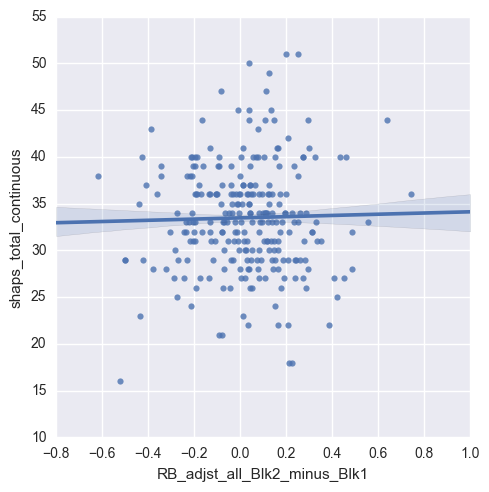

In [8]:
df_standard_mdd = df_standard.loc[df_standard['feasibility'] == 'MDD'] # just looking at the MDDs here
%Rpush df_standard_mdd
%R reward_learning_shaps <- cor.test(df_standard_mdd$shaps_total_continuous,df_standard_mdd$RB_adjst_all_Blk2_minus_Blk1,method="pearson")
%R print (reward_learning_shaps) 
reward_learning_shaps = sns.lmplot(y='shaps_total_continuous', x = 'RB_adjst_all_Blk2_minus_Blk1', data=df_standard_mdd,ci=68)

## Discriminability

/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Contrasts set to contr.sum for the following variables: feasibility, site

  warnings.warn(x, RRuntimeWarning)


Anova Table (Type 3 tests)

Response: dis_adjst_all1_Total
            Effect     df  MSE      F p.value
1      feasibility 1, 286 0.06 3.66 +     .06
2             site 3, 286 0.06   1.58     .19
3 feasibility:site 3, 286 0.06   0.09     .97


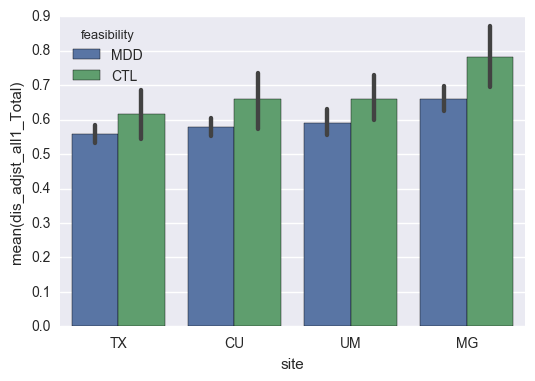

In [9]:
disc_plot = sns.barplot(y='dis_adjst_all1_Total', x = 'site', hue = 'feasibility', data=df_standard, ci=68)
%R disc_anova <- aov_ez("ProjectSpecificID",dv = "dis_adjst_all1_Total",data = df_standard,between=c("feasibility", "site"),anova_table=list(correction="none", es = "none"))
%R print(disc_anova)

/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Converting to factor: partic_age

  warnings.warn(x, RRuntimeWarning)
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Contrasts set to contr.sum for the following variables: feasibility, site, partic_age, partic_gender

  warnings.warn(x, RRuntimeWarning)


Anova Table (Type 3 tests)

Response: dis_adjst_all1_Total
            Effect      df  MSE      F p.value
1      feasibility  1, 239 0.06 3.36 +     .07
2             site  3, 239 0.06   2.01     .11
3       partic_age 46, 239 0.06   0.73     .90
4    partic_gender  1, 239 0.06   0.51     .48
5 feasibility:site  3, 239 0.06   0.20     .89


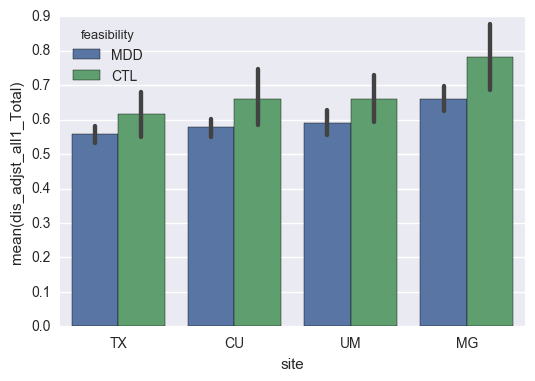

In [18]:
disc_plot = sns.barplot(y='dis_adjst_all1_Total', x = 'site', hue = 'feasibility', data=df_standard, ci=68)
%R disc_anova <- aov_ez("ProjectSpecificID",dv = "dis_adjst_all1_Total",data = df_standard,between=c("feasibility", "site"),covariate=c("partic_age", "partic_gender"),anova_table=list(correction="none", es = "none"))
%R print(disc_anova)

## Accuracy

/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Contrasts set to contr.sum for the following variables: feasibility, site_x

  warnings.warn(x, RRuntimeWarning)


Anova Table (Type 3 tests)

Response: response
                            Effect     df  MSE         F p.value
1                      feasibility 1, 286 0.03    4.48 *     .04
2                           site_x 3, 286 0.03      1.43     .23
3               feasibility:site_x 3, 286 0.03      0.04     .99
4                            block 1, 286 0.00      1.40     .24
5                feasibility:block 1, 286 0.00      0.26     .61
6                     site_x:block 3, 286 0.00      0.10     .96
7         feasibility:site_x:block 3, 286 0.00      0.80     .49
8                           length 1, 286 0.01 49.56 ***  <.0001
9               feasibility:length 1, 286 0.01      0.00     .98
10                   site_x:length 3, 286 0.01      1.51     .21
11       feasibility:site_x:length 3, 286 0.01      0.65     .59
12                    block:length 1, 286 0.01      1.17     .28
13        feasibility:block:length 1, 286 0.01      0.12     .73
14             site_x:block:length 3, 286 0

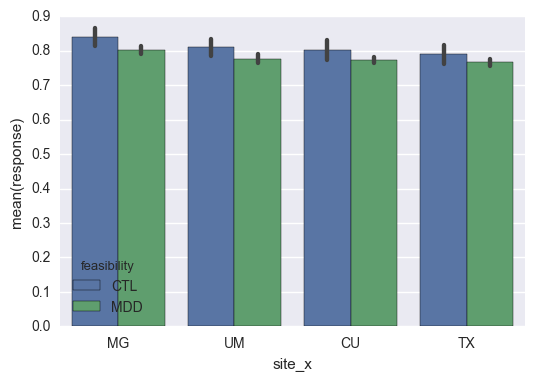

In [10]:
acc_plot = sns.barplot(y='response', x = 'site_x', data=df_trial, hue = 'feasibility', ci=68, units = 'subj_idx')
%Rpush df_trial
%R acc_anova <- aov_ez("subj_idx",dv = "response",data = df_trial ,between=c("feasibility", "site_x"),within=c("block","length"),anova_table=list(correction="none", es = "none"))
%R print(acc_anova)

**Adding age and gender as covariates**


Error in `[.data.frame`(data, , between, drop = FALSE) : 
  undefined columns selected


/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in `[.data.frame`(data, , between, drop = FALSE) : 
  undefined columns selected

  warnings.warn(x, RRuntimeWarning)
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In addition: 
  warnings.warn(x, RRuntimeWarning)
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 1: More than one observation per cell, aggregating the data using mean (i.e, fun.aggregate = mean)! 

  warnings.warn(x, RRuntimeWarning)
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 2: More than one observation per cell, aggregating the data using mean (i.e, fun.aggregate = mean)! 

  warnings.warn(x, RRuntimeWarning)


Anova Table (Type 3 tests)

Response: RB_adjst_all_Blk2_minus_Blk1
                            Effect      df  MSE       F p.value
1                      feasibility  1, 239 0.17    0.32     .57
2                           site_x  3, 239 0.17    1.01     .39
3                       partic_age 46, 239 0.17    1.01     .45
4                    partic_gender  1, 239 0.17    0.19     .66
5               feasibility:site_x  3, 239 0.17    1.79     .15
6                            block  1, 239 0.00 Inf ***  <.0001
7                feasibility:block  1, 239 0.00 Inf ***  <.0001
8                     site_x:block  3, 239 0.00 Inf ***  <.0001
9                 partic_age:block 46, 239 0.00 Inf ***  <.0001
10             partic_gender:block  1, 239 0.00 Inf ***  <.0001
11        feasibility:site_x:block  3, 239 0.00    <NA>    <NA>
12                          length  1, 239 0.00 Inf ***  <.0001
13              feasibility:length  1, 239 0.00 Inf ***  <.0001
14                   site_x:length  3

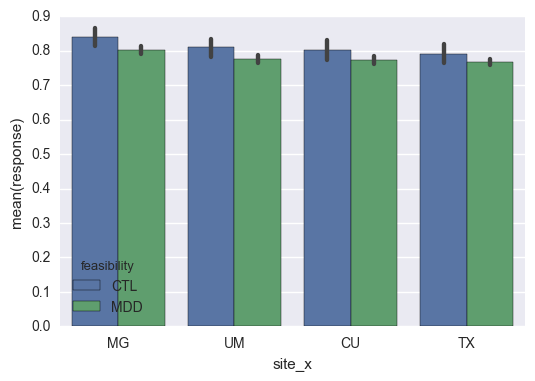

In [24]:
acc_plot = sns.barplot(y='response', x = 'site_x', data=df_trial, hue = 'feasibility', ci=68, units = 'subj_idx')
%Rpush df_trial
%R acc_anova <- aov_ez("subj_idx",dv = "response",data = df_trial ,between=c("feasibility", "site_x"),within=c("block","length"),covariate=c("partic_age","partic_gender", "dis_adjst_all1_Total),anova_table=list(correction="none", es = "none"))
%R print(acc_anova)

/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Contrasts set to contr.sum for the following variables: feasibility, site_x, partic_gender

  warnings.warn(x, RRuntimeWarning)


Anova Table (Type 3 tests)

Response: RB_adjst_all_Blk2_minus_Blk1
                            Effect     df  MSE       F p.value
1                      feasibility 1, 284 0.17    0.27     .60
2                           site_x 3, 284 0.17    0.52     .67
3                       partic_age 1, 284 0.17    0.22     .64
4                    partic_gender 1, 284 0.17    0.12     .73
5               feasibility:site_x 3, 284 0.17    1.22     .30
6                            block 1, 284 0.00    <NA>    <NA>
7                feasibility:block 1, 284 0.00    <NA>    <NA>
8                     site_x:block 3, 284 0.00 Inf ***  <.0001
9                 partic_age:block 1, 284 0.00 Inf ***  <.0001
10             partic_gender:block 1, 284 0.00 Inf ***  <.0001
11        feasibility:site_x:block 3, 284 0.00 Inf ***  <.0001
12                          length 1, 284 0.00    0.00    >.99
13              feasibility:length 1, 284 0.00    0.00    >.99
14                   site_x:length 3, 284 0.00    0

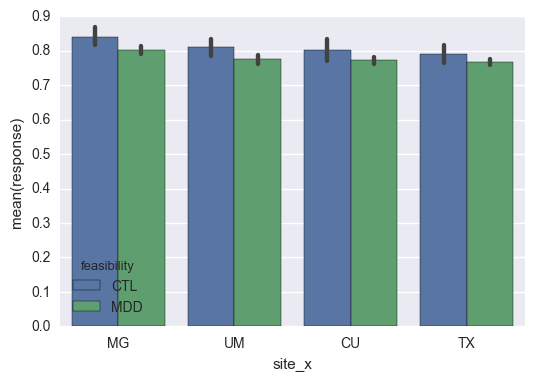

In [28]:
acc_plot = sns.barplot(y='response', x = 'site_x', data=df_trial, hue = 'feasibility', ci=68, units = 'subj_idx')
%Rpush df_trial
%R acc_anova <- aov_ez("subj_idx",dv = "RB_adjst_all_Blk2_minus_Blk1",data = df_trial ,between=c("feasibility", "site_x"),within=c("block","length"),covariate=c("partic_age","partic_gender"),factorize = FALSE, anova_table=list(correction="none", es = "none"))
%R print(acc_anova)

## Reaction Time

/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Contrasts set to contr.sum for the following variables: feasibility, site_x

  warnings.warn(x, RRuntimeWarning)


Anova Table (Type 3 tests)

Response: rt
                            Effect     df      MSE         F p.value
1                      feasibility 1, 286 59264.28    5.54 *     .02
2                           site_x 3, 286 59264.28      0.42     .74
3               feasibility:site_x 3, 286 59264.28      1.41     .24
4                            block 1, 286  3540.32      0.72     .40
5                feasibility:block 1, 286  3540.32      0.76     .38
6                     site_x:block 3, 286  3540.32      0.66     .58
7         feasibility:site_x:block 3, 286  3540.32      0.18     .91
8                           length 1, 286  1566.47 43.86 ***  <.0001
9               feasibility:length 1, 286  1566.47      0.01     .92
10                   site_x:length 3, 286  1566.47      0.32     .81
11       feasibility:site_x:length 3, 286  1566.47      0.46     .71
12                    block:length 1, 286   794.17  10.68 **    .001
13        feasibility:block:length 1, 286   794.17      0.08  

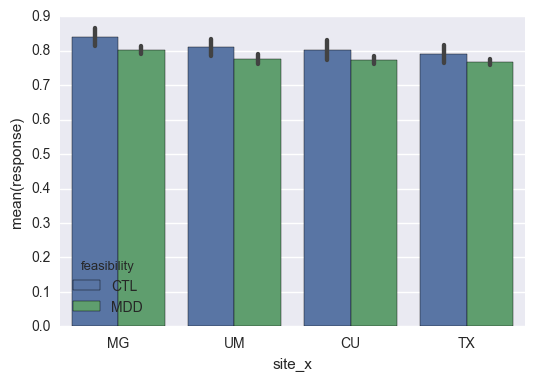

In [12]:
rt_plot = sns.barplot(y='response', x = 'site_x', data=df_trial, hue = 'feasibility', ci=68, units = 'subj_idx')
%R rt_anova <- aov_ez("subj_idx","rt",data = df_trial,between=c("feasibility", "site_x"),within=c("block","length"),anova_table=list(correction="none", es = "none"))
%R print (rt_anova)

**Adding age and gender as covariates**

/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Converting to factor: partic_age

  warnings.warn(x, RRuntimeWarning)
/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Contrasts set to contr.sum for the following variables: feasibility, site_x, partic_age, partic_gender

  warnings.warn(x, RRuntimeWarning)


Anova Table (Type 3 tests)

Response: rt
                            Effect      df      MSE         F p.value
1                      feasibility  1, 239 51311.43    6.33 *     .01
2                           site_x  3, 239 51311.43      0.87     .46
3                       partic_age 46, 239 51311.43  1.98 ***   .0005
4                    partic_gender  1, 239 51311.43      0.42     .52
5               feasibility:site_x  3, 239 51311.43      0.66     .58
6                            block  1, 239  3172.16      0.00     .96
7                feasibility:block  1, 239  3172.16      1.13     .29
8                     site_x:block  3, 239  3172.16    2.16 +     .09
9                 partic_age:block 46, 239  3172.16   1.74 **    .004
10             partic_gender:block  1, 239  3172.16      1.02     .31
11        feasibility:site_x:block  3, 239  3172.16      0.66     .57
12                          length  1, 239  1432.20 35.16 ***  <.0001
13              feasibility:length  1, 239  1432.

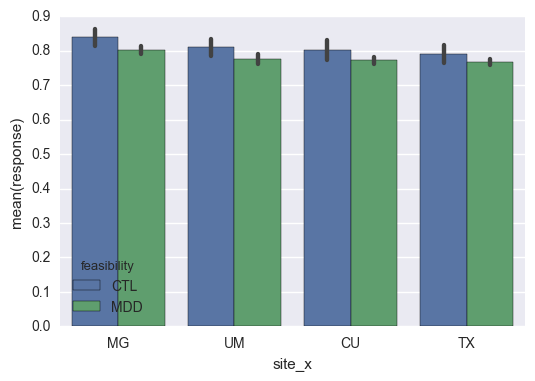

In [13]:
rt_plot = sns.barplot(y='response', x = 'site_x', data=df_trial, hue = 'feasibility', ci=68, units = 'subj_idx')
%R rt_anova <- aov_ez("subj_idx","rt",data = df_trial,between=c("feasibility", "site_x"),within=c("block","length"),covariate=c("partic_age","partic_gender"),anova_table=list(correction="none", es = "none"))
%R print (rt_anova)

# HDDM Analysis

Some functions that help later on when correlating parameters w/ self-report. 

In [10]:
def get_param(item):
    '''Returns the paramerter from the genstats() data'''
    if len(item) == 18:
        param = item[0]
    else:
        param = np.nan
    return(param)

In [11]:
def get_group(item):
    '''Returns the group info from the genstats() data'''
    if len(item) == 18:
        group = item[7:10]
    else:
        group = np.nan
    return(group)

In [12]:
def get_id(item):
    '''Returns the id info from the genstats() data'''
    if len(item) == 18:
        sub_id = item[12:18]
    else:
        sub_id = np.nan
    return(sub_id)

In [4]:
all_data = hddm.load_csv('Data/prt_trial_compact.csv')
all_data['rt'] = all_data['rt'] / 1000 # convert to seconds

Basic model that just looks at group

In [5]:
embarc_prt_acc_group = hddm.HDDM(all_data, depends_on={'v': 'feasibility', 'a': 'feasibility', 't':'feasibility'})
embarc_prt_acc_group.find_starting_values()
embarc_prt_acc_group.sample(10000, burn=1000, dbname = 'embarc_prt_acc_group.db', db = 'pickle')
embarc_prt_acc_group.save('embarc_prt_acc_group')

 [-----------------100%-----------------] 10001 of 10000 complete in 3547.5 sec

In [9]:
embarc_prt_acc_group.dic_info

{'DIC': -8014.6909198110807,
 'deviance': -8842.4267232400653,
 'pD': 827.73580342898458}

P_v(MDD > CTL) =  0.000666666666667
P_v(CTL > MDD) =  0.999333333333


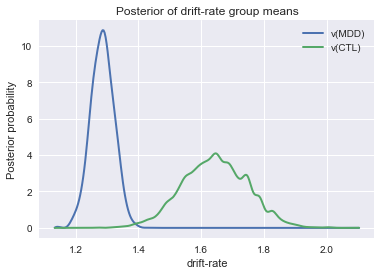

In [6]:
v_MDD, v_CTL = embarc_prt_acc_group.nodes_db.node[['v(MDD)','v(CTL)']]
hddm.analyze.plot_posterior_nodes([v_MDD, v_CTL])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')
plt.savefig('ctl_mdd_drift_rate_more_samples.pdf')

print ("P_v(MDD > CTL) = ", (v_MDD.trace() > v_CTL.trace()).mean())
print ("P_v(CTL > MDD) = ", (v_CTL.trace() > v_MDD.trace()).mean())

P_a(MDD > CTL) =  0.996777777778
P_a(CTL > MDD) =  0.00322222222222


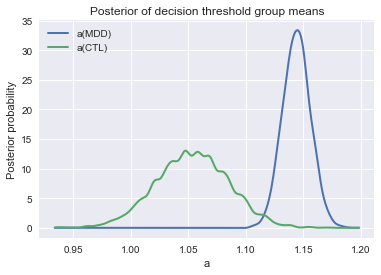

In [7]:
a_MDD, a_CTL = embarc_prt_acc_group.nodes_db.node[['a(MDD)','a(CTL)']]
hddm.analyze.plot_posterior_nodes([a_MDD, a_CTL])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of decision threshold group means')
plt.savefig('ctl_mdd_a_more_samples.pdf')

print ("P_a(MDD > CTL) = ", (a_MDD.trace() > a_CTL.trace()).mean())
print ("P_a(CTL > MDD) = ", (a_CTL.trace() > a_MDD.trace()).mean())

P_t(MDD > CTL) =  0.244
P_t(CTL > MDD) =  0.756


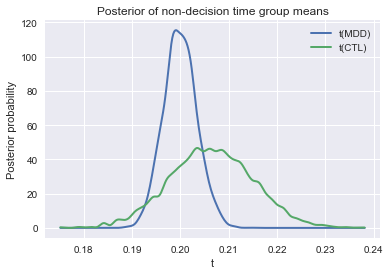

In [8]:
t_MDD, t_CTL = embarc_prt_acc_group.nodes_db.node[['t(MDD)','t(CTL)']]
hddm.analyze.plot_posterior_nodes([t_MDD, t_CTL])
plt.xlabel('t')
plt.ylabel('Posterior probability')
plt.title('Posterior of non-decision time group means')
plt.savefig('ctl_mdd_a_more_samples.pdf')

print ("P_t(MDD > CTL) = ", (t_MDD.trace() > t_CTL.trace()).mean())
print ("P_t(CTL > MDD) = ", (t_CTL.trace() > t_MDD.trace()).mean())

Do the parameters for this model correlate with any self-report measures?

In [41]:
embarc_prt_acc_group_stats = embarc_prt_acc_group.gen_stats()
embarc_prt_acc_group_stats['mean'].count()

891

In [45]:
embarc_prt_acc_group_stats = embarc_prt_acc_group.gen_stats()
embarc_prt_acc_group_stats.to_csv('embarc_prt_acc_group_stats.csv')
embarc_prt_acc_group_stats = pd.read_csv('embarc_prt_acc_group_stats.csv')
embarc_prt_acc_group_stats.rename(columns={'Unnamed: 0': 'to_extract'}, inplace=True)

# get column info and merge this with the clinical data
embarc_prt_acc_group_stats = embarc_prt_acc_group_stats[['to_extract', 'mean']]
embarc_prt_acc_group_stats['param'] = embarc_prt_acc_group_stats.to_extract.apply(get_param)
embarc_prt_acc_group_stats['group'] = embarc_prt_acc_group_stats.to_extract.apply(get_group)
embarc_prt_acc_group_stats['ProjectSpecificID'] = embarc_prt_acc_group_stats.to_extract.apply(get_id)
embarc_prt_acc_group_stats = pd.merge(embarc_prt_acc_group_stats, df_compact, on='ProjectSpecificID')

,to_extract,mean,param,group,ProjectSpecificID,feasibility,shaps_total_dichotomous,shaps_total_continuous,severity1,conmed_16,conmed_11,conmed_06,conmed_01,partic_age,partic_gender,masq2_29,hamd_09
0,a(CTL),1.053723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,a(CTL),1.053723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a(CTL),1.053723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,a(CTL),1.053723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,a(CTL),1.053723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



	Pearson's product-moment correlation

data:  embarc_prt_acc_group_stats_param$mean and embarc_prt_acc_group_stats_param$shaps_total_continuous
t = 1.4719, df = 255, p-value = 0.1423
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.03092589  0.21176873
sample estimates:
       cor 
0.09178427 




	Pearson's product-moment correlation

data:  embarc_prt_acc_group_stats_param$mean and embarc_prt_acc_group_stats_param$shaps_total_continuous
t = -0.84924, df = 255, p-value = 0.3965
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.17433636  0.06970941
sample estimates:
        cor 
-0.05310641 




	Pearson's product-moment correlation

data:  embarc_prt_acc_group_stats_param$mean and embarc_prt_acc_group_stats_param$shaps_total_continuous
t = -0.19138, df = 255, p-value = 0.8484
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1341498  0.1105413
sample estimates:
        cor 
-0.01198366 



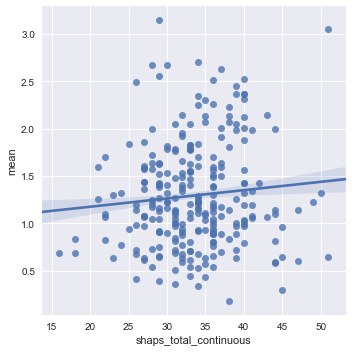

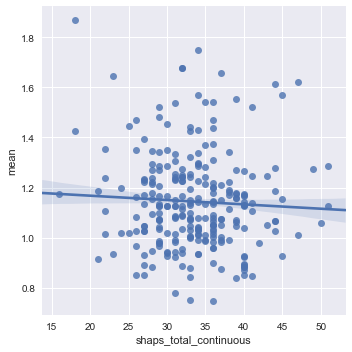

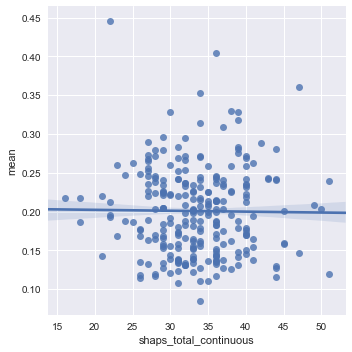

In [46]:
# for MDD subjects, are there any correlations with anhedonia and a parameter?

params = ['v','a','t']
for param in params:
    embarc_prt_acc_group_stats_param = embarc_prt_acc_group_stats[embarc_prt_acc_group_stats['param'] == param]
    embarc_prt_acc_group_stats_param = embarc_prt_acc_group_stats_param[embarc_prt_acc_group_stats_param['group'] == 'MDD']
    corr_param = sns.lmplot(y='mean', x = 'shaps_total_continuous', data=embarc_prt_acc_group_stats_param,ci=68)

    %Rpush embarc_prt_acc_group_stats_param
    %R corr_param <- cor.test(embarc_prt_acc_group_stats_param$mean,embarc_prt_acc_group_stats_param$shaps_total_continuous,method="pearson")
    %R print (corr_param)

In [49]:
all_data = hddm.load_csv('Data/prt_trial_compact.csv')
all_data['rt'] = all_data['rt'] / 1000 # convert to seconds
rich_data = all_data[all_data['length'] == 'short']
lean_data = all_data[all_data['length'] == 'long']

In [52]:
embarc_prt_rich_acc_group = hddm.HDDM(rich_data, depends_on= {'v': 'feasibility', 'a': 'feasibility'})
embarc_prt_rich_acc_group.sample(10000, burn=1000, dbname = 'embarc_prt_rich_acc_group.db', db='pickle')
embarc_prt_rich_acc_group.save('embarc_prt_rich_acc_group')

 [-----------------100%-----------------] 10000 of 10000 complete in 2637.8 sec

In [53]:
embarc_prt_rich_acc_group.dic_info

{'DIC': -9815.7186603783193,
 'deviance': -10599.700045635758,
 'pD': 783.98138525743889}

P_v(MDD > CTL) =  0.000666666666667
P_v(CTL > MDD) =  0.999333333333


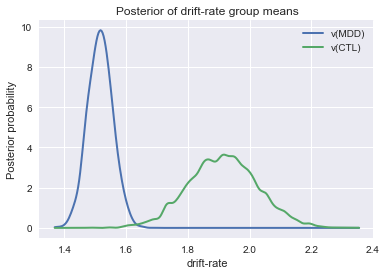

In [67]:
v_MDD, v_CTL = embarc_prt_rich_acc_group.nodes_db.node[['v(MDD)','v(CTL)']]
hddm.analyze.plot_posterior_nodes([v_MDD, v_CTL])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')
plt.savefig('ctl_mdd_drift_rate_more_samples.pdf')

print ("P_v(MDD > CTL) = ", (v_MDD.trace() > v_CTL.trace()).mean())
print ("P_v(CTL > MDD) = ", (v_CTL.trace() > v_MDD.trace()).mean())

P_a(MDD > CTL) =  0.997333333333
P_a(CTL > MDD) =  0.00266666666667


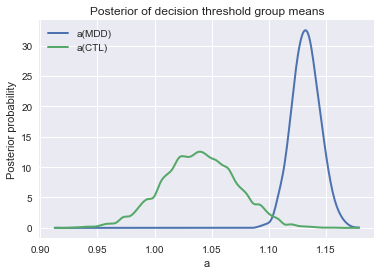

In [68]:
a_MDD, a_CTL = embarc_prt_rich_acc_group.nodes_db.node[['a(MDD)','a(CTL)']]
hddm.analyze.plot_posterior_nodes([a_MDD, a_CTL])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of decision threshold group means')
plt.savefig('ctl_mdd_a_more_samples.pdf')

print ("P_a(MDD > CTL) = ", (a_MDD.trace() > a_CTL.trace()).mean())
print ("P_a(CTL > MDD) = ", (a_CTL.trace() > a_MDD.trace()).mean())

Do we see the same correlation in the rich trials that we saw for the sigdep data? (in MDDs, threshold was negatively correlated with anhedonia)

In [64]:
embarc_prt_rich_acc_group_stats = embarc_prt_rich_acc_group.gen_stats()
embarc_prt_rich_acc_group_stats.to_csv('embarc_prt_rich_acc_group_stats.csv')
embarc_prt_rich_acc_group_stats = pd.read_csv('embarc_prt_rich_acc_group_stats.csv')
embarc_prt_rich_acc_group_stats.rename(columns={'Unnamed: 0': 'to_extract'}, inplace=True)

# get column info and merge this with the clinical data
embarc_prt_rich_acc_group_stats = embarc_prt_rich_acc_group_stats[['to_extract', 'mean']]
embarc_prt_rich_acc_group_stats['param'] = embarc_prt_rich_acc_group_stats.to_extract.apply(get_param)
embarc_prt_rich_acc_group_stats['group'] = embarc_prt_rich_acc_group_stats.to_extract.apply(get_group)
embarc_prt_rich_acc_group_stats['ProjectSpecificID'] = embarc_prt_rich_acc_group_stats.to_extract.apply(get_id)
embarc_prt_rich_acc_group_stats = pd.merge(embarc_prt_rich_acc_group_stats, df_compact, on='ProjectSpecificID')


	Pearson's product-moment correlation

data:  embarc_prt_rich_acc_group_stats_param$mean and embarc_prt_rich_acc_group_stats_param$shaps_total_continuous
t = 2.0972, df = 255, p-value = 0.03696
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.00797946 0.24861665
sample estimates:
      cor 
0.1302152 




	Pearson's product-moment correlation

data:  embarc_prt_rich_acc_group_stats_param$mean and embarc_prt_rich_acc_group_stats_param$shaps_total_continuous
t = -0.55555, df = 255, p-value = 0.579
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.15646622  0.08796802
sample estimates:
        cor 
-0.03476906 



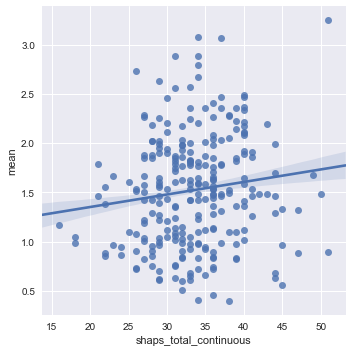

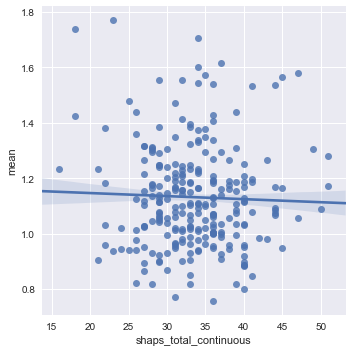

In [66]:
# for MDD subjects, are there any correlations with anhedonia and a parameter?

params = ['v','a']
for param in params:
    embarc_prt_rich_acc_group_stats_param = embarc_prt_rich_acc_group_stats[embarc_prt_rich_acc_group_stats['param'] == param]
    embarc_prt_rich_acc_group_stats_param = embarc_prt_rich_acc_group_stats_param[embarc_prt_rich_acc_group_stats_param['group'] == 'MDD']
    corr_param = sns.lmplot(y='mean', x = 'shaps_total_continuous', data=embarc_prt_rich_acc_group_stats_param,ci=68)

    %Rpush embarc_prt_rich_acc_group_stats_param
    %R corr_param <- cor.test(embarc_prt_rich_acc_group_stats_param$mean,embarc_prt_rich_acc_group_stats_param$shaps_total_continuous,method="pearson")
    %R print (corr_param)


	Pearson's product-moment correlation

data:  embarc_prt_rich_acc_group_stats_param$mean and embarc_prt_rich_acc_group_stats_param$shaps_total_continuous
t = 2.0972, df = 255, p-value = 0.03696
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.00797946 0.24861665
sample estimates:
      cor 
0.1302152 




	Pearson's product-moment correlation

data:  embarc_prt_rich_acc_group_stats_param$mean and embarc_prt_rich_acc_group_stats_param$shaps_total_continuous
t = -0.55555, df = 255, p-value = 0.579
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.15646622  0.08796802
sample estimates:
        cor 
-0.03476906 



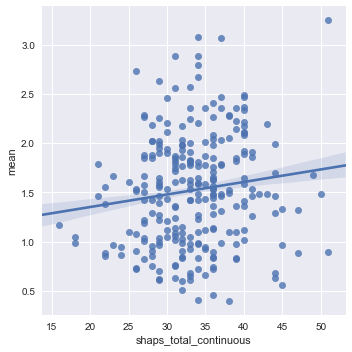

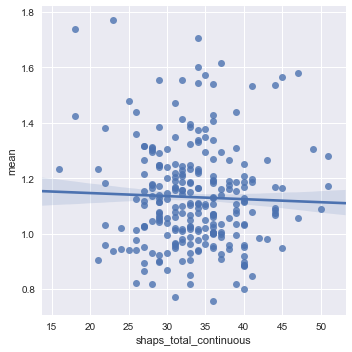

In [70]:
# Is this still true when the controls are included?
# YES

params = ['v','a']
for param in params:
    embarc_prt_rich_acc_group_stats_param = embarc_prt_rich_acc_group_stats[embarc_prt_rich_acc_group_stats['param'] == param]
    embarc_prt_rich_acc_group_stats_param = embarc_prt_rich_acc_group_stats_param[embarc_prt_rich_acc_group_stats_param['group'] == 'MDD']
    corr_param = sns.lmplot(y='mean', x = 'shaps_total_continuous', data=embarc_prt_rich_acc_group_stats_param,ci=68)

    %Rpush embarc_prt_rich_acc_group_stats_param
    %R corr_param <- cor.test(embarc_prt_rich_acc_group_stats_param$mean,embarc_prt_rich_acc_group_stats_param$shaps_total_continuous,method="pearson")
    %R print (corr_param)

Looking at just the lean stim..

In [69]:
embarc_prt_lean_acc_group = hddm.HDDM(lean_data, depends_on= {'v': 'feasibility', 'a': 'feasibility'})
embarc_prt_lean_acc_group.sample(10000, burn=1000, dbname = 'embarc_prt_lean_acc_group.db', db='pickle')
embarc_prt_lean_acc_group.save('embarc_prt_lean_acc_group')

 [-----------------100%-----------------] 10001 of 10000 complete in 2678.8 sec

In [71]:
embarc_prt_lean_acc_group.dic_info

{'DIC': -1522.1472373156562,
 'deviance': -2321.7899858711298,
 'pD': 799.64274855547364}

P_v(MDD > CTL) =  0.0112222222222
P_v(CTL > MDD) =  0.988777777778


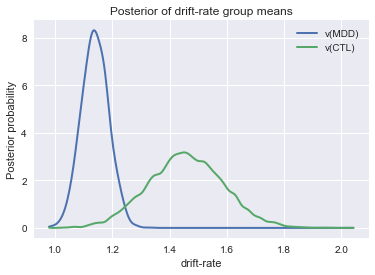

In [72]:
v_MDD, v_CTL = embarc_prt_lean_acc_group.nodes_db.node[['v(MDD)','v(CTL)']]
hddm.analyze.plot_posterior_nodes([v_MDD, v_CTL])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')

print ("P_v(MDD > CTL) = ", (v_MDD.trace() > v_CTL.trace()).mean())
print ("P_v(CTL > MDD) = ", (v_CTL.trace() > v_MDD.trace()).mean())

P_a(MDD > CTL) =  0.996444444444
P_a(CTL > MDD) =  0.00355555555556


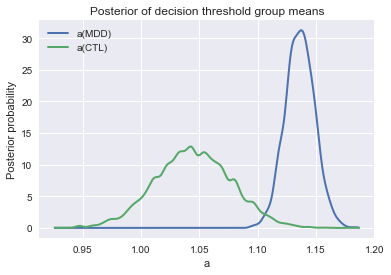

In [73]:
a_MDD, a_CTL = embarc_prt_lean_acc_group.nodes_db.node[['a(MDD)','a(CTL)']]
hddm.analyze.plot_posterior_nodes([a_MDD, a_CTL])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of decision threshold group means')

print ("P_a(MDD > CTL) = ", (a_MDD.trace() > a_CTL.trace()).mean())
print ("P_a(CTL > MDD) = ", (a_CTL.trace() > a_MDD.trace()).mean())

In [74]:
embarc_prt_lean_acc_group_stats = embarc_prt_rich_acc_group.gen_stats()
embarc_prt_lean_acc_group_stats.to_csv('embarc_prt_lean_acc_group_stats.csv')
embarc_prt_lean_acc_group_stats = pd.read_csv('embarc_prt_lean_acc_group_stats.csv')
embarc_prt_lean_acc_group_stats.rename(columns={'Unnamed: 0': 'to_extract'}, inplace=True)

# get column info and merge this with the clinical data
embarc_prt_lean_acc_group_stats = embarc_prt_lean_acc_group_stats[['to_extract', 'mean']]
embarc_prt_lean_acc_group_stats['param'] = embarc_prt_lean_acc_group_stats.to_extract.apply(get_param)
embarc_prt_lean_acc_group_stats['group'] = embarc_prt_lean_acc_group_stats.to_extract.apply(get_group)
embarc_prt_lean_acc_group_stats['ProjectSpecificID'] = embarc_prt_lean_acc_group_stats.to_extract.apply(get_id)
embarc_prt_lean_acc_group_stats = pd.merge(embarc_prt_lean_acc_group_stats, df_compact, on='ProjectSpecificID')


	Pearson's product-moment correlation

data:  embarc_prt_lean_acc_group_stats_param$mean and embarc_prt_lean_acc_group_stats_param$shaps_total_continuous
t = 2.0972, df = 255, p-value = 0.03696
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.00797946 0.24861665
sample estimates:
      cor 
0.1302152 




	Pearson's product-moment correlation

data:  embarc_prt_lean_acc_group_stats_param$mean and embarc_prt_lean_acc_group_stats_param$shaps_total_continuous
t = -0.55555, df = 255, p-value = 0.579
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.15646622  0.08796802
sample estimates:
        cor 
-0.03476906 



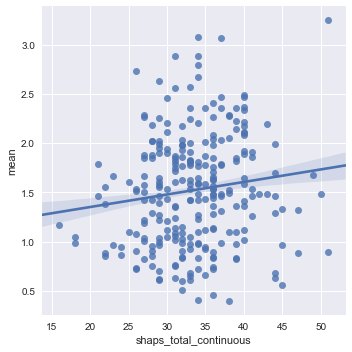

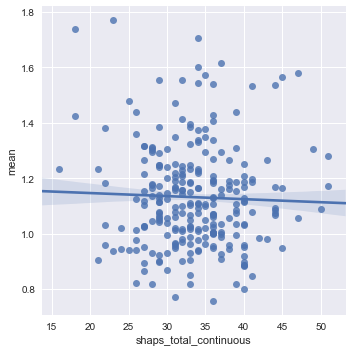

In [75]:
# for MDD subjects, are there any correlations with anhedonia and a parameter?

params = ['v','a']
for param in params:
    embarc_prt_lean_acc_group_stats_param = embarc_prt_lean_acc_group_stats[embarc_prt_lean_acc_group_stats['param'] == param]
    embarc_prt_lean_acc_group_stats_param = embarc_prt_lean_acc_group_stats_param[embarc_prt_lean_acc_group_stats_param['group'] == 'MDD']
    corr_param = sns.lmplot(y='mean', x = 'shaps_total_continuous', data=embarc_prt_lean_acc_group_stats_param,ci=68)

    %Rpush embarc_prt_lean_acc_group_stats_param
    %R corr_param <- cor.test(embarc_prt_lean_acc_group_stats_param$mean,embarc_prt_lean_acc_group_stats_param$shaps_total_continuous,method="pearson")
    %R print (corr_param)


	Pearson's product-moment correlation

data:  embarc_prt_lean_acc_group_stats_param$mean and embarc_prt_lean_acc_group_stats_param$shaps_total_continuous
t = -0.81767, df = 291, p-value = 0.4142
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.16157894  0.06707768
sample estimates:
        cor 
-0.04787785 




	Pearson's product-moment correlation

data:  embarc_prt_lean_acc_group_stats_param$mean and embarc_prt_lean_acc_group_stats_param$shaps_total_continuous
t = 1.3446, df = 291, p-value = 0.1798
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.03633565  0.19144281
sample estimates:
       cor 
0.07857906 



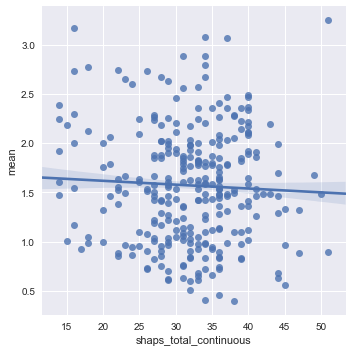

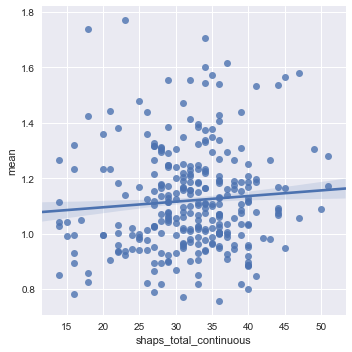

In [76]:
# Does this hold up when controls are included?

params = ['v','a']
for param in params:
    embarc_prt_lean_acc_group_stats_param = embarc_prt_lean_acc_group_stats[embarc_prt_lean_acc_group_stats['param'] == param]
    corr_param = sns.lmplot(y='mean', x = 'shaps_total_continuous', data=embarc_prt_lean_acc_group_stats_param,ci=68)

    %Rpush embarc_prt_lean_acc_group_stats_param
    %R corr_param <- cor.test(embarc_prt_lean_acc_group_stats_param$mean,embarc_prt_lean_acc_group_stats_param$shaps_total_continuous,method="pearson")
    %R print (corr_param)

Not sure what below is....

In [ ]:
full_model = hddm.load_csv('Data/prt_trial_compact.csv')
full_model['rt'] = full_model['rt'] / 1000
del full_model['Unnamed: 0']
del full_model['outlier']
m_full_model = hddm.HDDMRegressor(full_model, ['v ~ feasibility', 'a ~ feasibility'])
m_full_model.sample(1000, burn=100)

In [ ]:
v_MDD = m_full_model.nodes_db.node[['v(MDD)']]
hddm.analyze.plot_posterior_nodes([v_MDD])
plt.xlabel('t')
plt.ylabel('Posterior probability')
plt.title('Posterior of non-decision time group means')
plt.savefig('ctl_mdd_a_more_samples.pdf')

print ("P_v(MDD > CTL) = ", (v_MDD.trace() > v_CTL.trace()).mean())
print ("P_v(CTL > MDD) = ", (v_CTL.trace() > v_MDD.trace()).mean())

In [ ]:
full_model = hddm.load_csv('Data/prt_trial_compact.csv')
full_model['rt'] = full_model['rt'] / 1000
del full_model['Unnamed: 0']
del full_model['outlier']
m_full_model = hddm.HDDMRegressor(full_model, ['v ~ 0 + feasibilty*length*block', 'a ~ 0 + feasibility*length*block'])
m_full_model.sample(1000, burn=100)